# Modulacion de palabras para clasificación

In [1]:
#Importamos algunas librerias necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from nltk.tokenize import word_tokenize
import we_to_signal as wes

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Modulacion

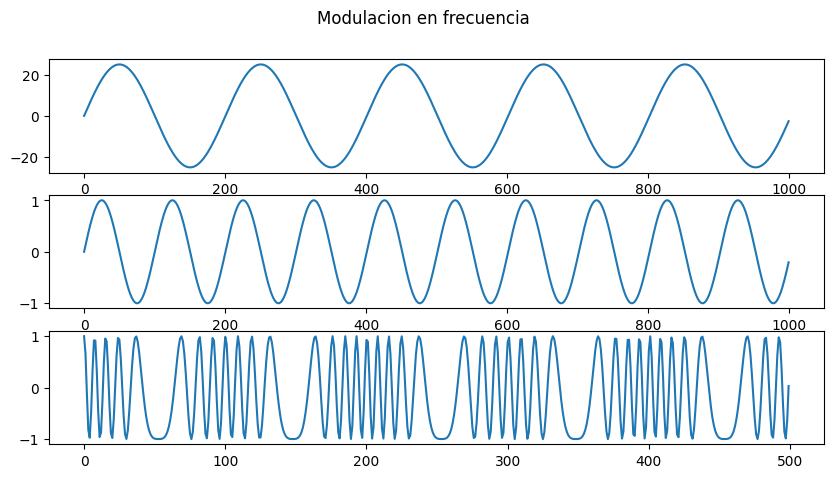

In [2]:
# Samples per second
sps = 44100

# Duration
duration_s = 5.0

# ac: amplitude of the carrier. Should be kept at 1.0 in this script
# you would modify it if you were micing it with, or modulating other,
# waveforms.

# carrier_hz: Frequency of the carrier
# fm_hz: Frequency of the frequency modulator
# k_p: deviation constant
carrier_amplitude = 1.0
carrier_hz = 440.0
fm_hz = 220.0
k = 25.0

# Our final waveform is going to be calculated as the cosine of carrier and
# frequency modulated terms.

# First, define our range of sample numbers
each_sample_number = np.arange(duration_s * sps)

# Create the term that create the carrier
carrier = 2 * np.pi * each_sample_number * carrier_hz / sps

# Now create the term that is the frequency modulator
modulator = k * np.sin(2 * np.pi * each_sample_number * fm_hz / sps)

# Now create the modulated waveform, and attenuate it
waveform = np.cos(carrier + modulator)
waveform_quiet = waveform * 0.3

fig,ax = plt.subplots(3,figsize=(10,5))

fig.suptitle("Modulacion en frecuencia")
ax[0].plot(modulator[:1000])
ax[1].plot(np.sin(carrier[:1000]))
ax[2].plot(waveform[:500])

## Carga de corpus y calculo de embbeddings

In [3]:
#Con los poemas separados, los metemos en un diccionario de dataframes
import os

data_path = "data/"
emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

json_files = sorted([pos_json for pos_json in os.listdir(data_path) if pos_json.endswith('.json')])
json_files.remove('Poems.json')
json_files.remove('missing.json')

em_poems = {}
for e in emotion_list:
    f = open(data_path+e+".json")
    df_ = pd.DataFrame(json.load(f))
    em_poems[e] = df_
em_poems["anger"]

,poem,id
0,i do know this it's nothing i can hold\nlast ...,10
1,the fear o' hell's a hangman's whip\nto haud t...,18
2,but since i laid a hand thereon\nand found a h...,88
3,falsely i pointed to sum in text\nseriously he...,99
4,i'll wear my jealous reflection\njuice of lemo...,125
...,...,...
2461,new snow on a leaf\nlike granulated sugar\nmak...,93124
2462,new earth and old earth\na trio of guardians\n...,93138
2463,destructions despair\nconstructions hope toge...,93217
2464,hot dry summers will\nbake paint right off the...,93226


In [4]:
#Carga de embeddings
from gensim.models import Word2Vec
from gensim.models import FastText

emotion_list = ["anger", "anticipation", "disgust", "fear", "joy", "sadness", "surprise", "trust"]

poems_w2v = {}
poems_fst = {}

for e in emotion_list:
    w2v_lines = Word2Vec.load("embeddings_poems/w2v_model_"+e)
    fst_lines = FastText.load("embeddings_poems/fst_model_"+e)
    poems_w2v[e] = w2v_lines
    poems_fst[e] = fst_lines

## Simulitud de palabras entre emociones

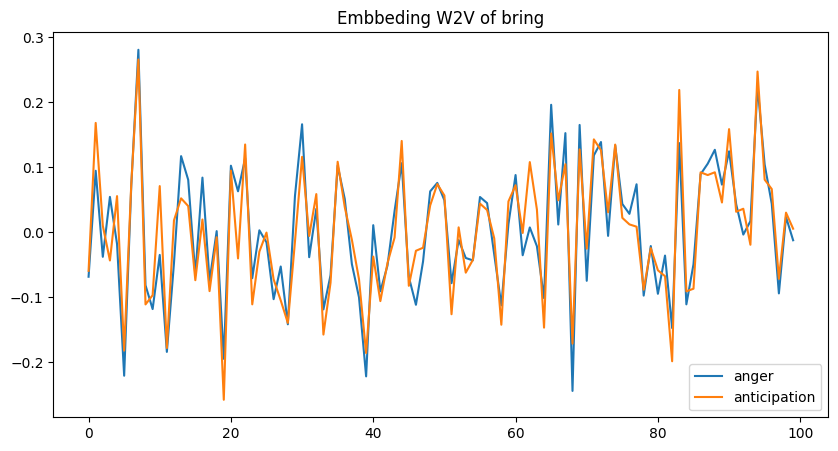

In [5]:
#Parametros
word = "bring"
emotion_a = "anger"
emotion_b = "anticipation"

#Extraccion del embbeding
embbeding_emotion_a = poems_w2v[emotion_a].wv.get_vector(word,norm=True)
embbeding_emotion_b = poems_w2v[emotion_b].wv.get_vector(word,norm=True)

plt.figure(figsize=(10,5))
plt.title("Embbeding W2V of "+word)
plt.plot(embbeding_emotion_a)
plt.plot(embbeding_emotion_b)
plt.legend([emotion_a,emotion_b])

PearsonRResult(statistic=0.9157850532955002, pvalue=1.3232929273565894e-40)

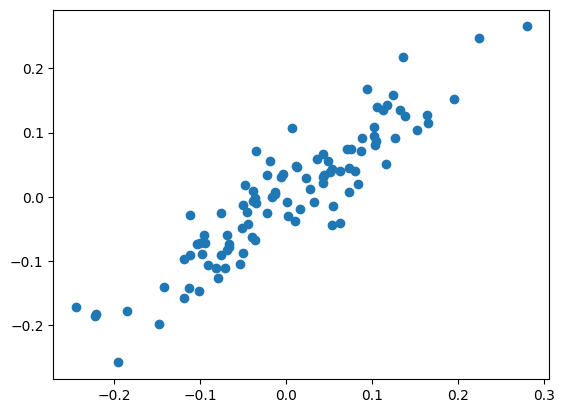

In [6]:
#Scatter plot para observar su correlación y correlacion pearson
from scipy.stats import pearsonr

plt.scatter(embbeding_emotion_a,embbeding_emotion_b)
display(pearsonr(embbeding_emotion_a,embbeding_emotion_b))

In [7]:
#Calculamos la interseccion entre palabras de fst,w2v y todas las emociones

words_intersection = set()
for emotion in emotion_list:
    fst = set(poems_fst[emotion].wv.key_to_index.keys())
    w2v = set(poems_w2v[emotion].wv.key_to_index.keys())
    intersection = fst & w2v
    if not words_intersection:
        words_intersection = words_intersection.union(intersection)
    else:
        words_intersection = words_intersection.intersection(intersection)

display(len(words_intersection))

677

In [8]:
#Eliminamos las stopwords de la interseccion
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
words_intersection = words_intersection - stop_words
len(words_intersection)

562

In [9]:
#Funciones de procesamiento y obtencion de frecuencia de las palabras
from collections import Counter

def get_word_freq(dataframe:pd.DataFrame,col:str,emotion_list:list):
    """
    Calculates for Counter model of each emotion text corpus.

    Parameters
    ------------
    dataframe: pandas Dataframe with documents.
    col:str name of the column where the documents are.
    emotion_list: list with emotions

    Returns
    -----------
    dict:
        dictionary with keys(emotions_list) an each key with his self Counter model.
    """
    freq_dict = {}
    for emotion in emotion_list:
        tokens = dataframe[emotion][col].apply(lambda x: [token for token in word_tokenize(x)])
        l1 = tokens.values.tolist()
        l2 = [w for l in l1 for w in l ]
        freq_dict[emotion] = Counter(l2)
    return freq_dict

def text_clean(sent):
    """
    Clean the text of some chars
    
    Parameters
    -------------
    sent: str
        Sentence to be cleaned
    
    Returns
    -------------
    str:
        Sentence cleaned.
    """
    import re
    from unidecode import unidecode
    import unicodedata as ud

    d = {ord('\N{combining acute accent}'):None}
    sent = ud.normalize('NFD',sent).translate(d)
    sent = re.sub(r"[^\w .,;?!\n]+", "", sent)
    sent = re.sub(r"[^\w .,;?!]", " ", sent)
    sent = re.sub(r"[^\w .,]", ".", sent)
    sent = re.sub(r"[^\w ]", "", sent)
    sent = re.sub(r"[0-9]", "", sent)
    sent = re.sub(r"[α-ωςϑϕϜϝϞϠϰϱ]", "", sent)
    sent = re.sub(r"[ΓΔΕΖΗΘΙΚΛΜΝΞΟΠΡΣΤΥΦΧΨΩ]", "", sent)
    sent = re.sub(r"[A-Z]{2}", "", sent)
    return sent

In [10]:
#Creamos una copia de los poemas y calculamos la frecuencia de aparición de las palabras
em_poem_c = dict()

for emotion in emotion_list:
    em_poem_c[emotion] = em_poems[emotion].copy()

for emotion in emotion_list:
    em_poem_c[emotion]["poems_clean"] = em_poem_c[emotion]["poem"].apply(text_clean)

freq_dict = get_word_freq(em_poem_c,"poems_clean",emotion_list)

In [11]:
#Creamos el dataframe de las palabras con su correlacion pearson
from itertools import combinations

def create_correlation_df(models,emotion_list,words_intersection,freq_dict):
    """
    Crea un dataset con informacion de la correlacion de las palabras
    entre emociones añadiendo su frecuencia de aparicion en el corpus.
    """
    emotion_combinations = list(combinations(emotion_list,2))

    words_embbed_info = {}
    words_embbed_info["words"] = list(words_intersection)

    for emotion in emotion_list:
        words_embbed_info["f_"+emotion] = []

    for comb in emotion_combinations:
        words_embbed_info["P_"+str(comb)] = []

    for word in words_intersection:
        #Añadimos la frecuencia por cada emoción
        for emotion in emotion_list:
            words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

        #Calculamos la correlacion pearson para cada par de emociones.    
        for comb in emotion_combinations:
            emotion_a = comb[0]
            emotion_b = comb[1]

            words_embbed_info["P_"+str(comb)].append(pearsonr(models[emotion_a].wv.get_vector(word,norm=True),models[emotion_b].wv.get_vector(word,norm=True)))

    return pd.DataFrame(words_embbed_info)

In [12]:
words_embbed_w2v_info = create_correlation_df(poems_w2v,emotion_list,words_intersection,freq_dict)
words_embbed_fst_info = create_correlation_df(poems_fst,emotion_list,words_intersection,freq_dict)

display(words_embbed_w2v_info)
display(words_embbed_fst_info)

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,smoke,19,30,19,30,24,47,10,30,"(0.90491357225458, 3.884661006833367e-38)",...,"(0.8668642490914287, 2.1918314411028445e-31)","(0.8764387683364887, 7.191357776913847e-33)","(0.8856815524128249, 2.0063414166451346e-34)","(0.8694926440217517, 8.813357625761976e-32)","(0.8757903800048467, 9.144221030166929e-33)","(0.8829719044719826, 5.910415528148845e-34)","(0.8733874704197957, 2.201822995289244e-32)","(0.892814379001089, 1.0193951987463145e-35)","(0.8927819817912003, 1.0337721416282034e-35)","(0.8693166954728747, 9.373349105052055e-32)"
1,passing,10,52,6,28,28,39,7,37,"(0.8935231699570223, 7.495220090804015e-36)",...,"(0.8262925218927316, 3.5821498285952985e-26)","(0.8826191565983169, 6.789652038431661e-34)","(0.8829428909839498, 5.97832050478468e-34)","(0.8679875171662035, 1.4885205432338631e-31)","(0.8803814731374173, 1.619843180858462e-33)","(0.8734160517219294, 2.1791587486433372e-32)","(0.8619243348502984, 1.1538226216833126e-30)","(0.9054332035778055, 3.0081613389541966e-38)","(0.8971612394802945, 1.4931205187096212e-36)","(0.8839214284707322, 4.059993566158014e-34)"
2,dead,47,208,53,166,165,307,25,214,"(0.9157848462001312, 1.3234456720522744e-40)",...,"(0.8665263793481912, 2.460690561060579e-31)","(0.8813229998988148, 1.1259280175937241e-33)","(0.8845566205298742, 3.1522953907979274e-34)","(0.8820432176639768, 8.5069035292028e-34)","(0.8642187183648509, 5.378203298010753e-31)","(0.8662932834285874, 2.6646760126706878e-31)","(0.877825413163102, 4.282483722608812e-33)","(0.9027057725689296, 1.1328397896602243e-37)","(0.9013223771152472, 2.1866993689719926e-37)","(0.8910157827432902, 2.2033972763236334e-35)"
3,went,38,141,21,78,143,112,16,125,"(0.9129490407651056, 6.255762430671937e-40)",...,"(0.8591472066635195, 2.85434748032849e-30)","(0.8756307776050408, 9.699284724226758e-33)","(0.8870413595039152, 1.1546473449724458e-34)","(0.8745598126406832, 1.437368564535551e-32)","(0.8737866129581205, 1.9051565471728137e-32)","(0.8858860029803933, 1.8472328255204926e-34)","(0.8696033539895813, 8.477889843775535e-32)","(0.8894859726992952, 4.1998514338284043e-35)","(0.8806376636357461, 1.4676522387465929e-33)","(0.868664149963972, 1.177005213702097e-31)"
4,skies,12,62,8,38,103,92,5,65,"(0.8953456282535053, 3.3651473833660823e-36)",...,"(0.8159040978410124, 4.722149151582721e-25)","(0.8634504237847404, 6.955261192288659e-31)","(0.8762407285241213, 7.739995673194856e-33)","(0.8690757877260171, 1.019676869606354e-31)","(0.855633517148485, 8.73628494122113e-30)","(0.8813242145853923, 1.1253975658355182e-33)","(0.8632489822018199, 7.43843988504455e-31)","(0.867727563743818, 1.6284828939708883e-31)","(0.88836619660446, 6.694059163993997e-35)","(0.8553163191177727, 9.65052706267312e-30)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,write,8,38,8,20,40,32,5,51,"(0.9051496859232319, 3.459170193945655e-38)",...,"(0.846057883487381, 1.5945821224509377e-28)","(0.8648866204280475, 4.2953407767928e-31)","(0.835972373467548, 2.764070004971598e-27)","(0.826682904553251, 3.240516999318711e-26)","(0.8233377139219262, 7.588186303172786e-26)","(0.7988166825854359, 2.3480478115780344e-23)","(0.811605251250678, 1.3095970911661818e-24)","(0.8730129623819288, 2.5209363581888507e-32)","(0.8743786187181763, 1.5357319069218738e-32)","(0.8557505381645131, 8.420820290343638e-30)"
558,sat,21,55,10,39,64,78,9,79,"(0.9089663742110944, 5.078884723243564e-39)",...,"(0.844693357632957, 2.3735016982536807e-28)","(0.8815909326324575, 1.0146449196471703e-33)","(0.8761668353710305, 7.95500461372866e-33)","(0.8652594595328427, 3.7867438129476514e-31)","(0.8834386318054255, 4.916

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,smoke,19,30,19,30,24,47,10,30,"(0.8793997903514559, 2.3591932937795598e-33)",...,"(0.8851429783587036, 2.492320626737316e-34)","(0.8604980861181173, 1.8417049668169974e-30)","(0.8750420710459869, 1.2045865227099236e-32)","(0.8830497358347212, 5.7319541358402894e-34)","(0.8530827093755472, 1.9321280864479567e-29)","(0.8365961060373893, 2.330167772255707e-27)","(0.8715331619132808, 4.285589239892808e-32)","(0.8410676836601997, 6.705420502362052e-28)","(0.8998715717682558, 4.313449077092475e-37)","(0.8712894077777831, 4.674083717970582e-32)"
1,passing,10,52,6,28,28,39,7,37,"(0.8057787291306533, 5.009478332103384e-24)",...,"(0.8648852243272798, 4.297365193066579e-31)","(0.8566064725129974, 6.428310635458359e-30)","(0.8656166538244014, 3.3548823418092403e-31)","(0.8602668577271472, 1.9857859388878026e-30)","(0.855802942862935, 8.283178715191055e-30)","(0.7952610322250093, 5.05007531969262e-23)","(0.8554780718311144, 9.17322487304251e-30)","(0.8108565256817953, 1.5600396517837995e-24)","(0.8922803046292186, 1.283398468505159e-35)","(0.8276660407046043, 2.514819534501156e-26)"
2,dead,47,208,53,166,165,307,25,214,"(0.8876620096263884, 8.951662706190438e-35)",...,"(0.8442168015492301, 2.7247603800198e-28)","(0.8574877199317051, 4.859314046856734e-30)","(0.8745757133533246, 1.429036409292801e-32)","(0.8835557362835829, 4.693593649559328e-34)","(0.7113263334085925, 1.102216288448396e-16)","(0.7987448722250836, 2.3850073236625048e-23)","(0.795787644045935, 4.512886189220116e-23)","(0.8365488141078815, 2.3605930120399715e-27)","(0.891131891957626, 2.0972995359866057e-35)","(0.8722364515120546, 3.333075870738407e-32)"
3,went,38,141,21,78,143,112,16,125,"(0.8853651116589203, 2.2793389739047993e-34)",...,"(0.8959932949380635, 2.5226823337324175e-36)","(0.8774640372454405, 4.904853196207248e-33)","(0.8753335465854579, 1.082202127349068e-32)","(0.88986509597112, 3.582564162756352e-35)","(0.8375979636524487, 1.7685264945499572e-27)","(0.8368799477031686, 2.1554360585244477e-27)","(0.8658522950499623, 3.0967197430009402e-31)","(0.8663085951717625, 2.650784427752741e-31)","(0.8888184988567599, 5.548483337973817e-35)","(0.8815274830365695, 1.0399848593092734e-33)"
4,skies,12,62,8,38,103,92,5,65,"(0.8202467225246544, 1.6395845477556142e-25)",...,"(0.7968339869962398, 3.6056208675640725e-23)","(0.7698990064282508, 7.93107355867994e-21)","(0.8723254562839429, 3.2283734839067395e-32)","(0.8035652149271493, 8.241540425244423e-24)","(0.8265780485951004, 3.329023738080391e-26)","(0.7370993107620607, 2.2662980369487455e-18)","(0.8130815012746542, 9.253305681217507e-25)","(0.7278238647629044, 9.650362980085051e-18)","(0.8629984303091279, 8.085309116824348e-31)","(0.7701026817636878, 7.635276349470922e-21)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,write,8,38,8,20,40,32,5,51,"(0.8899803427597262, 3.4131627389708827e-35)",...,"(0.8922853872260256, 1.2805960352950322e-35)","(0.8937447112145442, 6.805275958910131e-36)","(0.8757248742073849, 9.368178126248514e-33)","(0.9086851663197988, 5.8667770191559195e-39)","(0.8424634253456291, 4.509649876413934e-28)","(0.8340826323604007, 4.616968332528578e-27)","(0.872122337830214, 3.472177104383366e-32)","(0.8827055867251187, 6.563084484859378e-34)","(0.9099148116130489, 3.111877161982059e-39)","(0.8983659674873953, 8.635139530931089e-37)"
558,sat,21,55,10,39,64,78,9,79,"(0.8851498364107773, 2.4854633724776336e-34)",...,"(0.9013310314487134, 2.1777871578675373e-37)","(0.8963593532851097, 2.1417450586639174e-36)","(0.874109640972101, 1.6939790988900298e-32)","(0.8781175555174138, 3.8363561115348245e-33)","(0.836216044770060

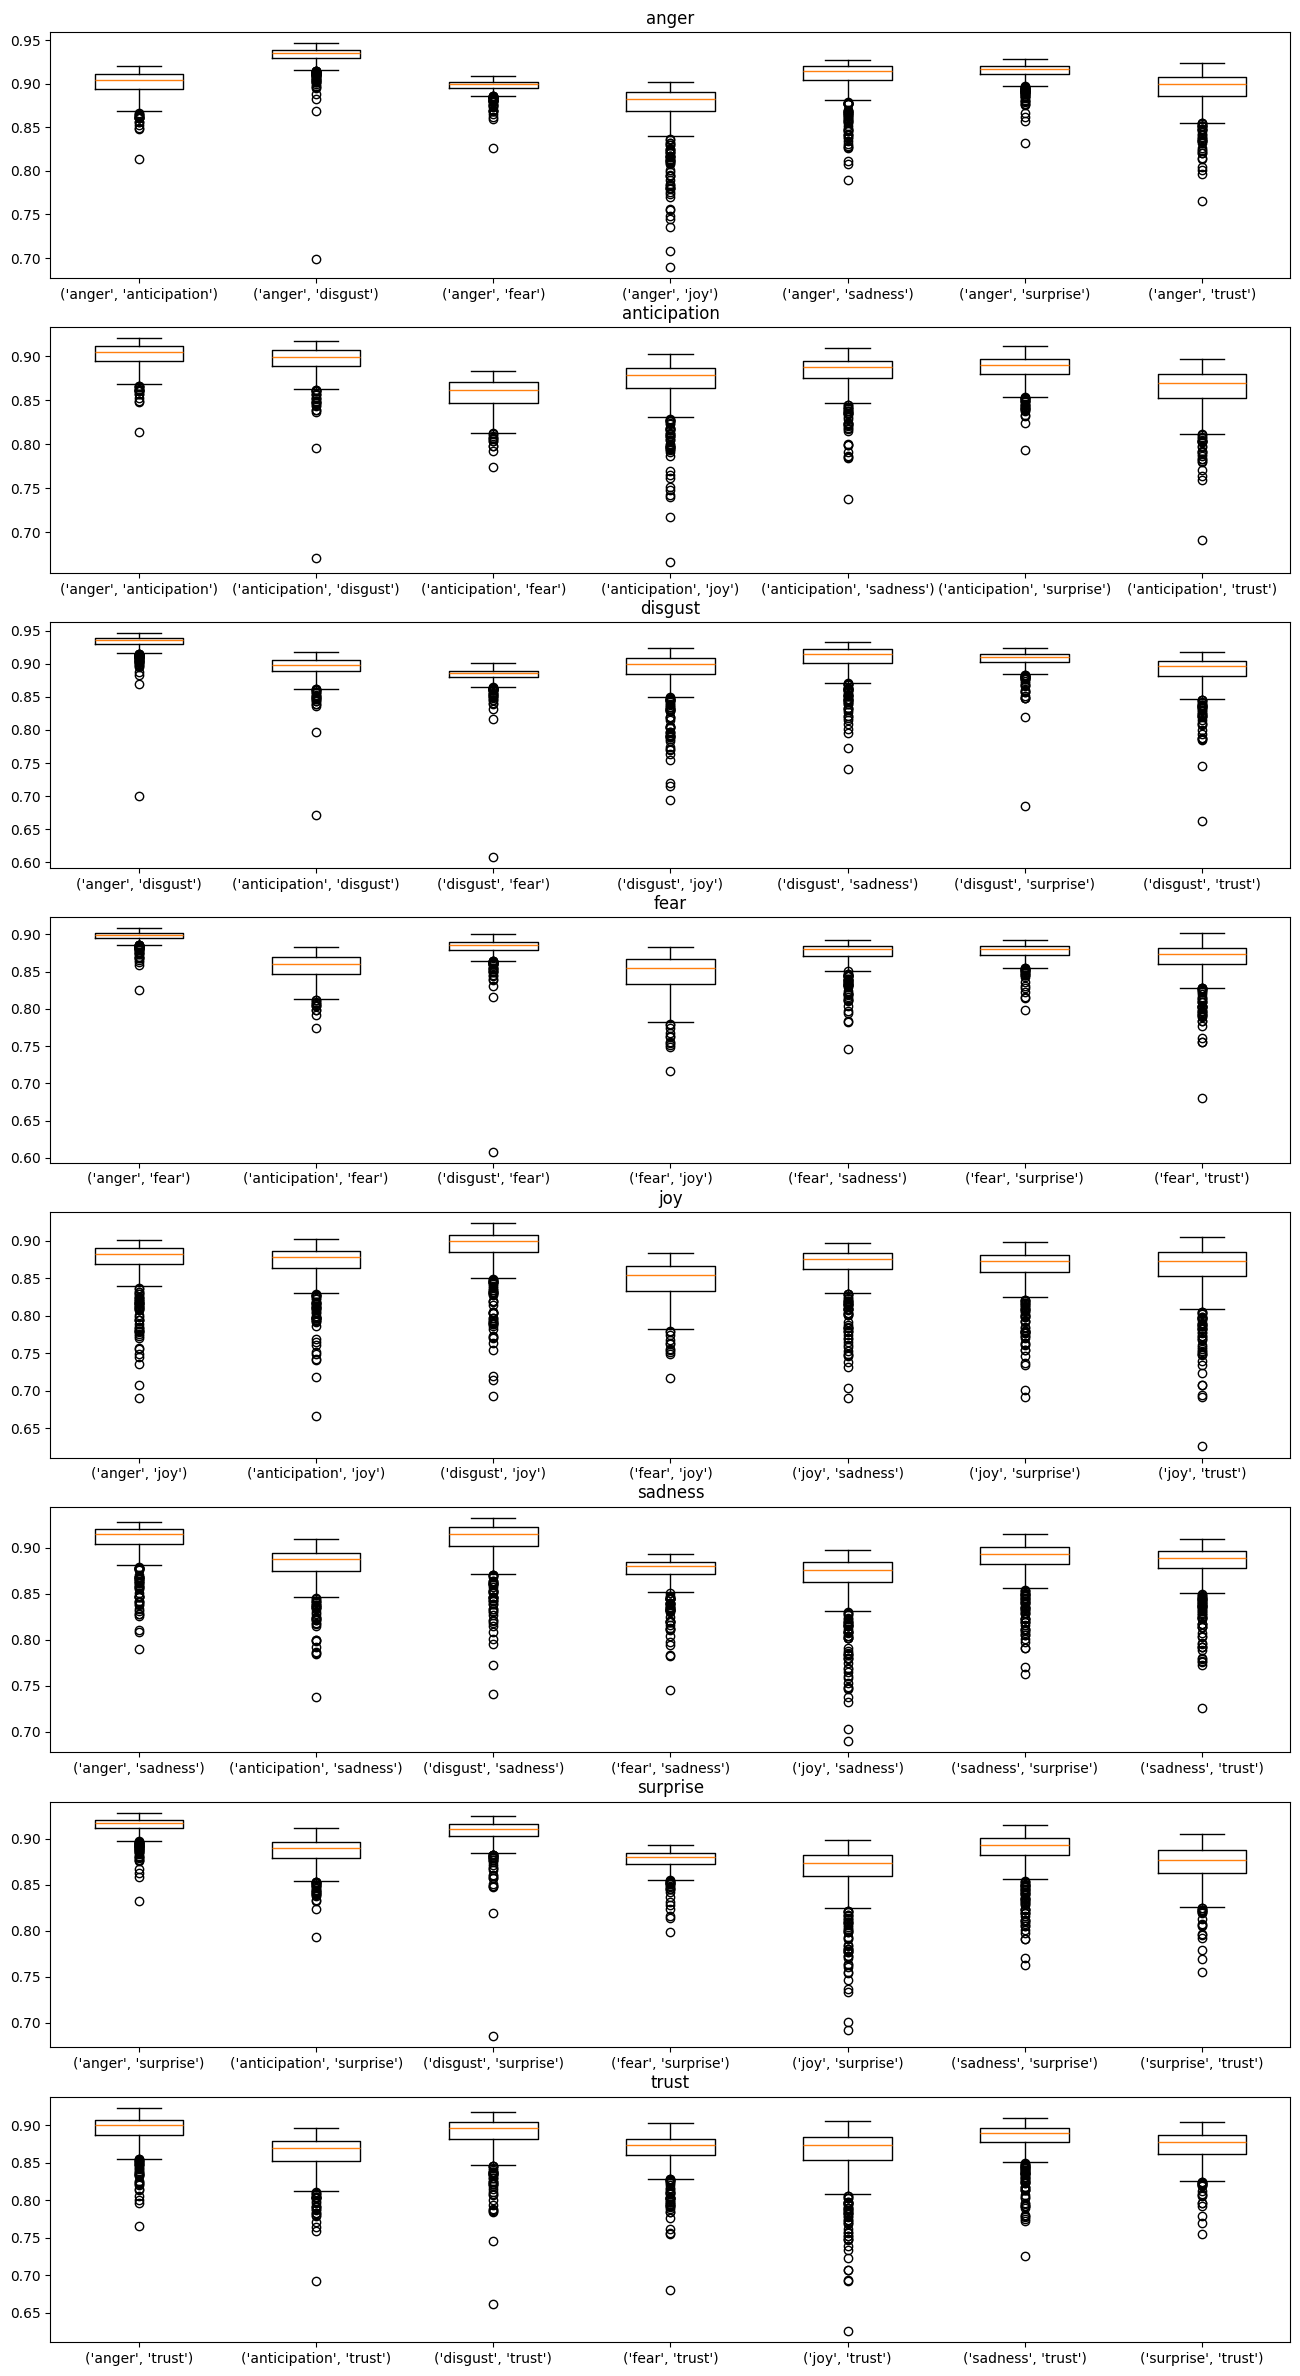

In [13]:
# Boxplots correlacion 
#sent = re.sub(r"[^\w .,;?!\n]+", "", sent)
import re
fig,ax = plt.subplots(8,figsize=(16,30))
columns = words_embbed_w2v_info.columns
i = 0
for emotion in emotion_list:
    data = []
    labels = []
    for column in columns:
        if emotion in column:
            if 'f_' in column:
                continue
            data.append([element[0] for element in words_embbed_w2v_info[column]])
            labels.append(re.sub(r"P_","",column))
    ax[i].boxplot(data)
    ax[i].set_xticklabels(labels)
    ax[i].set_title(emotion)
    i+=1

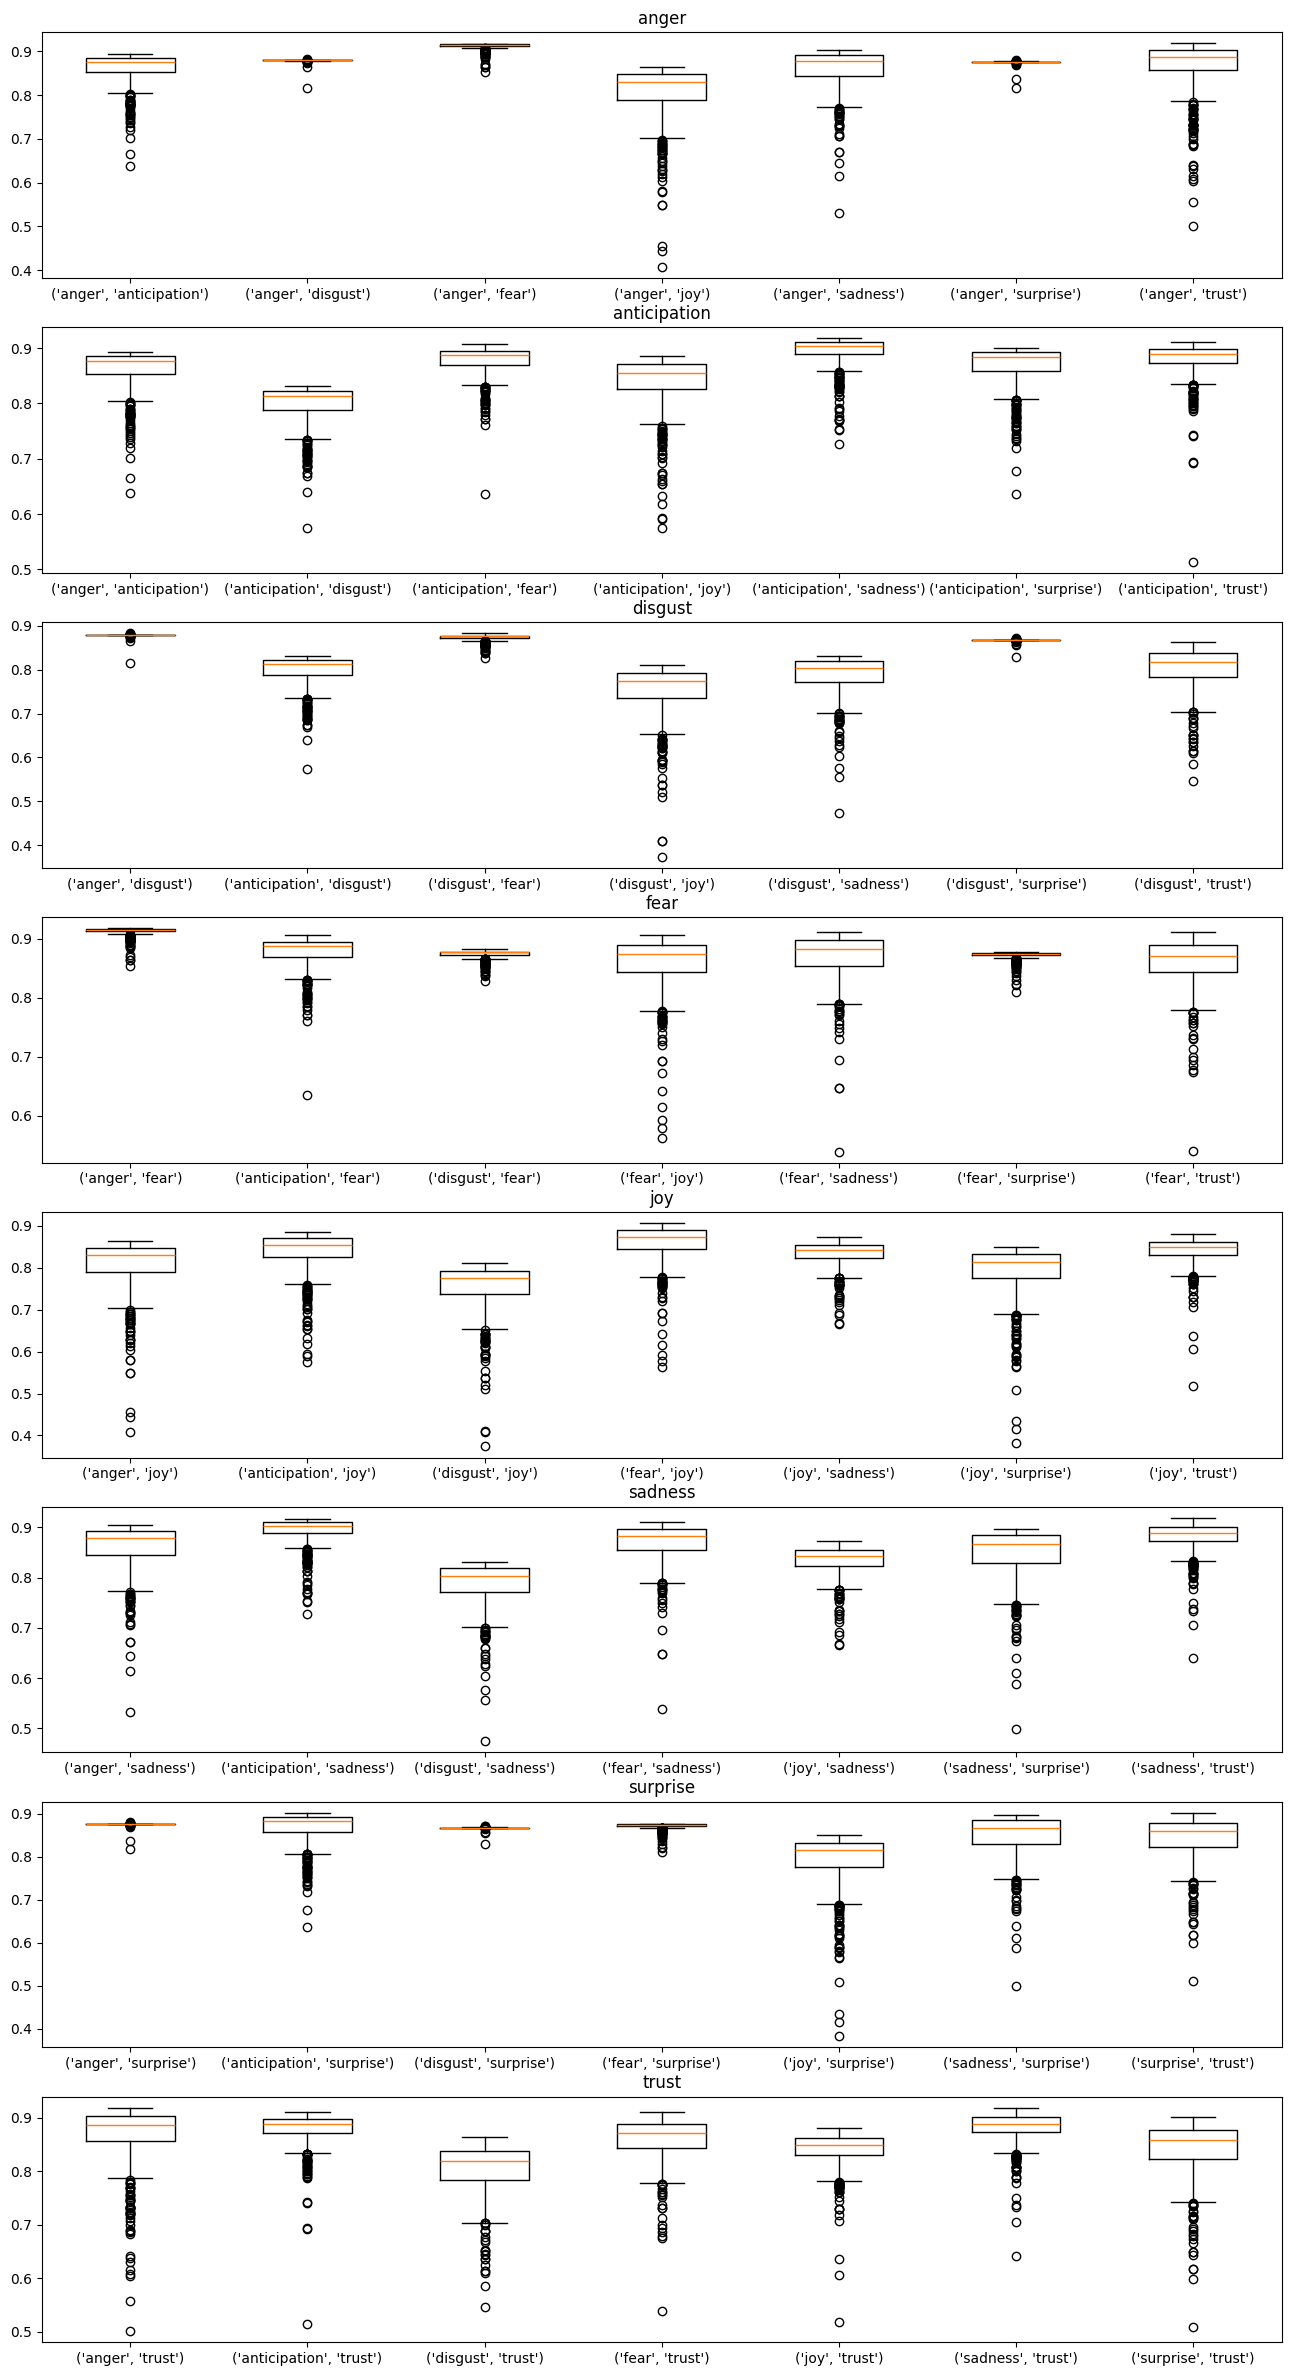

In [42]:
# Boxplots correlacion 
#sent = re.sub(r"[^\w .,;?!\n]+", "", sent)
import re
fig,ax = plt.subplots(8,figsize=(16,30))
columns = words_embbed_fst_info.columns
i = 0
for emotion in emotion_list:
    data = []
    labels = []
    for column in columns:
        if emotion in column:
            if 'f_' in column:
                continue
            data.append([element[0] for element in words_embbed_fst_info[column]])
            labels.append(re.sub(r"P_","",column))
    ax[i].boxplot(data)
    ax[i].set_xticklabels(labels)
    ax[i].set_title(emotion)
    i+=1

### Modulacion de embbedings

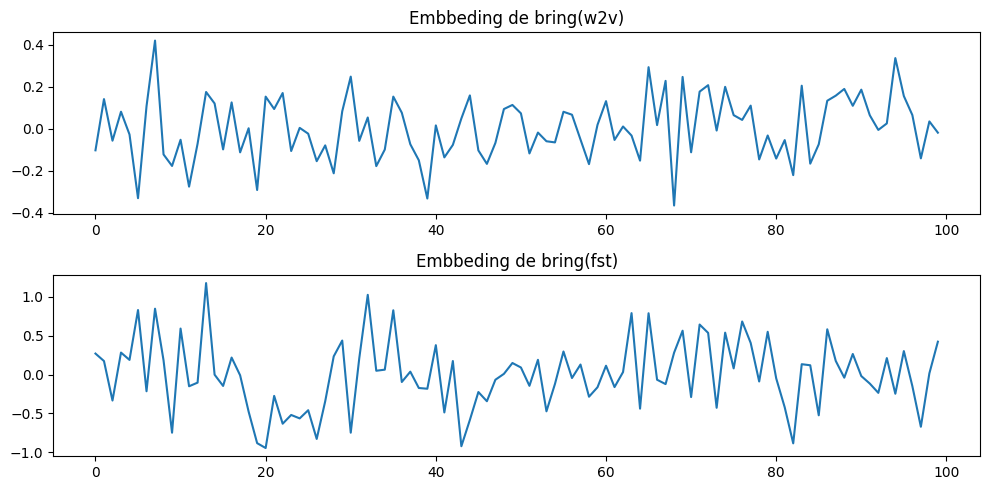

In [14]:
#Variables a ocupar
word = "bring"
emotion = "anger"
embbed_w2v = poems_w2v[emotion].wv.get_vector(word)
embbed_fst = poems_fst[emotion].wv.get_vector(word)

fig,ax = plt.subplots(2,figsize=(10,5))

ax[0].set_title("Embbeding de "+word+"(w2v)")
ax[0].plot(embbed_w2v)

ax[1].set_title("Embbeding de "+word+"(fst)")
ax[1].plot(embbed_fst)
fig.tight_layout()

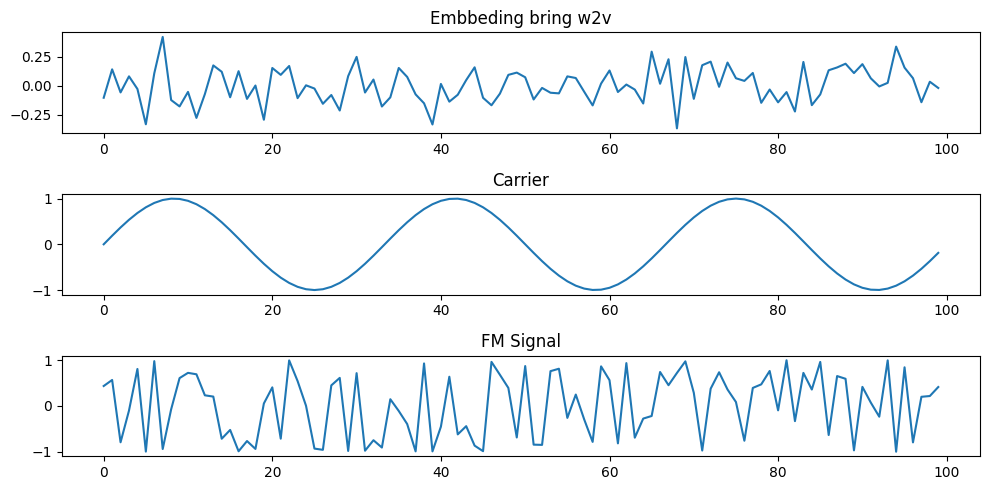

In [17]:
# Samples per second
sps = 100

# Duration
duration_s = 1.0

# ac: amplitude of the carrier. Should be kept at 1.0 in this script

# carrier_hz: Frequency of the carrier
# fm_hz: Frequency of the frequency modulator
# k_p: deviation constant
carrier_amplitude = 1.0
carrier_hz = 3.0
fm_hz = 50.0
k = 50

each_sample_number = np.arange(duration_s * sps)
carrier = 2 * np.pi * each_sample_number * carrier_hz / sps

#modulator = k * np.sin(2 * np.pi * each_sample_number * fm_hz / sps)
modulator = embbed_w2v
# Now create the modulated waveform, and attenuate it
waveform = np.cos(carrier + k*modulator)

fig,ax = plt.subplots(3,figsize=(10,5))
ax[0].set_title("Embbeding "+ word + " w2v")
ax[0].plot(embbed_w2v)

ax[1].set_title("Carrier")
ax[1].plot(np.sin(carrier))

ax[2].set_title("FM Signal")
ax[2].plot(waveform)
fig.tight_layout()

In [25]:
def modulate(x,carrier_hz,k,sps,duration_s):
    """Ocupa x para modular una carrier de amplitud 1 y frecuencia carrier_hz"""
    # Samples per second sps

    # Duration duration_s in seconds

    # carrier_hz: Frequency of the carrier
    # fm_hz: Frequency of the frequency modulator
    # k_p: deviation constant
    
    each_sample_number = np.arange(duration_s * sps)
    carrier = 2 * np.pi * each_sample_number * carrier_hz / sps

    modulator = x
    
    waveform = np.cos(carrier + k*modulator)

    return waveform

In [34]:
def create_correlation_df_mod(models,emotion_list,words_intersection,freq_dict,freq_a,freq_b,norm = False):
    emotion_combinations = list(combinations(emotion_list,2))

    words_embbed_info = {}
    words_embbed_info["words"] = list(words_intersection)

    for emotion in emotion_list:
        words_embbed_info["f_"+emotion] = []

    for comb in emotion_combinations:
        words_embbed_info["P_"+str(comb)] = []

    for word in words_intersection:
        #Añadimos la frecuencia por cada emoción
        for emotion in emotion_list:
            words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

        #Calculamos la correlacion pearson para cada par de emociones.    
        for comb in emotion_combinations:
            emotion_a = comb[0]
            emotion_b = comb[1]

            embbeding_a = models[emotion_a].wv.get_vector(word,norm=True)
            embbeding_b = models[emotion_b].wv.get_vector(word,norm=True)

            fm_embbed_a = modulate(embbeding_a,freq_a,50,100,1)
            fm_embbed_b = modulate(embbeding_b,freq_b,50,100,1)
            
            if norm:
                fm_embbed_a = fm_embbed_a/np.linalg.norm(fm_embbed_a)
                fm_embbed_b = fm_embbed_b/np.linalg.norm(fm_embbed_b)


            words_embbed_info["P_"+str(comb)].append(pearsonr(fm_embbed_a,fm_embbed_b))

    return pd.DataFrame(words_embbed_info)

In [40]:
words_embbed_fst_mod = create_correlation_df_mod(poems_fst,emotion_list,words_intersection,freq_dict,2,3)
words_embbed_w2v_mod = create_correlation_df_mod(poems_w2v,emotion_list,words_intersection,freq_dict,2,3)

display(words_embbed_fst_mod)
display(words_embbed_w2v_mod)

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,smoke,19,30,19,30,24,47,10,30,"(-0.03813040872960047, 0.7064358258344989)",...,"(0.11588837662298533, 0.2508913160094576)","(-0.015372372334982799, 0.8793446909891439)","(-0.031041920714567055, 0.7591551888529638)","(-0.050825479644881474, 0.6155342008071342)","(0.046277921263147094, 0.6475229727559102)","(0.10135801324878459, 0.3156563784483359)","(0.0021658945374426197, 0.9829372143790633)","(0.09235782958950364, 0.3607578519029924)","(-0.10588725510899913, 0.29440326627139457)","(0.019448221889526593, 0.8476989317619231)"
1,passing,10,52,6,28,28,39,7,37,"(-0.0962705545611704, 0.34068260651618454)",...,"(0.0358757251890517, 0.7230684382084083)","(-0.049309245912806554, 0.6261239788458736)","(0.042553848977785906, 0.6742086608965115)","(-0.030389547905414753, 0.7640672492688737)","(-4.320009146947324e-05, 0.9996596467689102)","(-0.05407239001712488, 0.5931223634911336)","(-0.019826057934095496, 0.8447767435022474)","(0.04394825785543608, 0.6641671247011443)","(-0.10527605098851649, 0.29721480845789866)","(-0.026527478841657515, 0.7933324461862128)"
2,dead,47,208,53,166,165,307,25,214,"(0.0277737325742247, 0.7838553197181731)",...,"(0.02029463072245168, 0.84115571965341)","(-0.07245229693338942, 0.47377145785830604)","(-0.021281420536350824, 0.8335409315800685)","(-0.06351371993544978, 0.5301439638839396)","(-0.09837287239418804, 0.33019304539190997)","(-0.11585172972574537, 0.25104222293272904)","(-0.016070130810438323, 0.8739122302304548)","(0.11994926568240508, 0.23455405186130157)","(-0.11026854838161018, 0.27476433923569743)","(0.05495889160893122, 0.5870678711187303)"
3,went,38,141,21,78,143,112,16,125,"(0.02711945965904984, 0.788826892912945)",...,"(0.1909245525119567, 0.05706867540731636)","(-0.0025108434941187407, 0.9802202379718523)","(-0.059843907254090355, 0.5542218514917333)","(0.12537188556749712, 0.21391685951513792)","(-0.03590392223302229, 0.7228596143969092)","(0.1424906631923492, 0.15729749604633234)","(0.14900779447186294, 0.13897528716002375)","(0.11370938800006644, 0.25997264222501076)","(-0.10013255615892241, 0.32157311179411685)","(0.0022174984412833337, 0.9825307451799433)"
4,skies,12,62,8,38,103,92,5,65,"(-0.13238981985726092, 0.189169000679312)",...,"(0.09296387908107726, 0.35760143211428086)","(-0.07931733299190873, 0.43278305553049856)","(-0.004818064086528525, 0.9620548290193754)","(-0.0036968720836686375, 0.9708804480090069)","(0.005562760444074449, 0.9561953111536254)","(-0.015754631853145594, 0.8763678662398332)","(0.03205248340438369, 0.7515650463551349)","(-0.01942718881568277, 0.8478616627658625)","(-0.20713714412898382, 0.038657662907917056)","(-0.17330004545421815, 0.08465643757124122)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,write,8,38,8,20,40,32,5,51,"(0.023325884647211338, 0.8178139550033028)",...,"(0.16077055438036547, 0.11006398366277798)","(0.015618196718318341, 0.8774301518809411)","(-0.05711531424107082, 0.5724592147602178)","(0.16273520818298404, 0.10572826110208915)","(0.01247298672186588, 0.9019752684877208)","(0.1067129979949109, 0.2906328112648929)","(-0.022226321469347006, 0.8262637594219621)","(0.1258449108235495, 0.21217982570483537)","(-0.12961113726815543, 0.19870672053999053)","(-0.007796285399186802, 0.9386364109272834)"
558,sat,21,55,10,39,64,78,9,79,"(0.060723436344095195, 0.5484035104088892)",...,"(0.13294730816608347, 0.1872961539655159)","(0.07530324846018138, 0.4564995660300824)","(-0.0777006089755443, 0.4422496361169061)","(0.04915079786854063, 0.6272350660894916)","(0.08561408594067563, 0.39703216749647)","(0.055485194429018066, 0.5834867937398651)","(0.08619654

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,smoke,19,30,19,30,24,47,10,30,"(-0.04330809465204014, 0.6687698878958824)",...,"(-0.1039967912233421, 0.3031564391229118)","(0.10779727423496774, 0.2857306406635855)","(-0.06611813179379877, 0.5133796229288965)","(-0.09547475285716023, 0.3447075084262744)","(-0.0026948278252676835, 0.9787711832843643)","(0.06618349101486773, 0.5129624360028626)","(0.0145512649484574, 0.8857446468894049)","(-0.0981163765042737, 0.3314616938015954)","(-0.1625742988831024, 0.10607827260628264)","(-0.02964174509933179, 0.7697093633451876)"
1,passing,10,52,6,28,28,39,7,37,"(-0.09114256266785829, 0.36713885219358233)",...,"(-0.09061289658701006, 0.36994150403000015)","(0.12964500679509977, 0.19858841877149191)","(-0.007063586531420519, 0.9443937127327688)","(-0.015872195635688063, 0.8754526889577874)","(0.05273531129848366, 0.602307009135417)","(0.1068067329406234, 0.2902068353864236)","(0.0767090079342696, 0.4481131039516168)","(-0.030048985844623014, 0.7666352540731715)","(-0.169675272271888, 0.09147246143615534)","(-0.06445836609746894, 0.5240318743722746)"
2,dead,47,208,53,166,165,307,25,214,"(-0.1410235430098296, 0.16166007770881632)",...,"(-0.12930611576386467, 0.19977440629945403)","(0.17340490834194117, 0.08446544674337478)","(-0.0159907982109697, 0.8745295913263957)","(0.13836381886802118, 0.16979723829811896)","(0.11695128854531622, 0.24654149700824773)","(0.05409790766077521, 0.5929476939233613)","(-0.07466929318328443, 0.4603098394500384)","(-0.04852826543340788, 0.6316085043907658)","(-0.07997452503258849, 0.42896819119445617)","(-0.18784334902590064, 0.0612739791185805)"
3,went,38,141,21,78,143,112,16,125,"(-0.10578573457102265, 0.2948690414695401)",...,"(-0.1414382893849485, 0.1604177827693119)","(0.09626996881360243, 0.34068555808995493)","(0.021213007633279424, 0.8340683681602726)","(0.1336364729366134, 0.1849996264142166)","(-0.1398703352246774, 0.16515186754571284)","(0.012426145819016621, 0.9023415704538839)","(-0.11592333593355234, 0.25074741644770626)","(-0.002332117164169304, 0.9816279423891009)","(-0.022958401604584996, 0.8206356819369528)","(0.02095337520868531, 0.8360706990819866)"
4,skies,12,62,8,38,103,92,5,65,"(-0.016814897230149818, 0.8681202412534689)",...,"(-0.04517938384397184, 0.6553504388776038)","(0.03544815725397111, 0.7262374337378557)","(0.07877311593972382, 0.43595670398550906)","(-0.016501133333726672, 0.8705595267953755)","(0.014465813122426951, 0.8864111129439559)","(-0.0067093667824031054, 0.9471780969095255)","(0.16952046164899, 0.09177296331659318)","(-0.10756820533517847, 0.28676168207110414)","(-0.2294453312872748, 0.021656876687897078)","(-0.12963028239764882, 0.1986398429089273)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,write,8,38,8,20,40,32,5,51,"(-0.060692349778227364, 0.548608649628139)",...,"(-0.0739325408848206, 0.46475987733247975)","(-0.02153882081340716, 0.8315571392559858)","(0.07433788762504466, 0.46230864325127313)","(0.14871986975673024, 0.13974898126142285)","(0.036477428049778035, 0.7186167308086874)","(0.06878926875929324, 0.496472570865108)","(-0.13560488334563203, 0.1785533059999318)","(-0.032221299242862184, 0.750299384248553)","(0.09876093891126984, 0.32827953044395203)","(-0.04882942276306378, 0.6294912048884712)"
558,sat,21,55,10,39,64,78,9,79,"(-0.04605934393887053, 0.6490773928903224)",...,"(-0.028849518407952045, 0.775699768787477)","(0.17764353607991093, 0.07702858483151014)","(-0.11419602126977699, 0.2579253368182864)","(-0.05654262102022241, 0.5763223033881966)","(-0.0211509699050608, 0.8345467182182887)","(0.06904239746419197, 0.49488569032644264)","(-0.037844194461714414, 

In [41]:
words_embbed_fst_mod_norm = create_correlation_df_mod(poems_fst,emotion_list,words_intersection,freq_dict,2,3,True)
words_embbed_w2v_mod_norm = create_correlation_df_mod(poems_w2v,emotion_list,words_intersection,freq_dict,2,3,True)

display(words_embbed_fst_mod_norm)
display(words_embbed_w2v_mod_norm)

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,smoke,19,30,19,30,24,47,10,30,"(-0.03813040872960051, 0.7064358258344977)",...,"(0.11588837662298532, 0.2508913160094576)","(-0.015372372334982806, 0.8793446909891439)","(-0.03104192071456704, 0.7591551888529638)","(-0.05082547964488149, 0.6155342008071342)","(0.04627792126314706, 0.6475229727559102)","(0.1013580132487846, 0.3156563784483359)","(0.0021658945374425764, 0.9829372143790633)","(0.09235782958950361, 0.3607578519029924)","(-0.10588725510899913, 0.29440326627139457)","(0.019448221889526593, 0.8476989317619231)"
1,passing,10,52,6,28,28,39,7,37,"(-0.09627055456117041, 0.34068260651618454)",...,"(0.035875725189051716, 0.7230684382084083)","(-0.049309245912806526, 0.6261239788458736)","(0.042553848977785864, 0.6742086608965115)","(-0.030389547905414732, 0.7640672492688737)","(-4.32000914695062e-05, 0.9996596467689102)","(-0.054072390017124876, 0.5931223634911336)","(-0.01982605793409549, 0.8447767435022474)","(0.04394825785543609, 0.6641671247011443)","(-0.10527605098851649, 0.29721480845789866)","(-0.026527478841657515, 0.7933324461862128)"
2,dead,47,208,53,166,165,307,25,214,"(0.027773732574224688, 0.7838553197181731)",...,"(0.020294630722451686, 0.84115571965341)","(-0.07245229693338946, 0.47377145785830604)","(-0.021281420536350803, 0.8335409315800685)","(-0.06351371993544974, 0.5301439638839396)","(-0.09837287239418799, 0.3301930453919109)","(-0.1158517297257454, 0.25104222293272904)","(-0.016070130810438316, 0.8739122302304548)","(0.1199492656824051, 0.23455405186130157)","(-0.11026854838161022, 0.27476433923569743)","(0.05495889160893119, 0.5870678711187303)"
3,went,38,141,21,78,143,112,16,125,"(0.027119459659049876, 0.788826892912945)",...,"(0.19092455251195667, 0.05706867540731636)","(-0.0025108434941187377, 0.9802202379718523)","(-0.05984390725409031, 0.5542218514917333)","(0.12537188556749712, 0.21391685951513792)","(-0.03590392223302229, 0.7228596143969092)","(0.1424906631923492, 0.15729749604633234)","(0.149007794471863, 0.13897528716002225)","(0.11370938800006641, 0.25997264222501076)","(-0.1001325561589224, 0.32157311179411685)","(0.002217498441283376, 0.9825307451799433)"
4,skies,12,62,8,38,103,92,5,65,"(-0.13238981985726095, 0.1891690006793119)",...,"(0.09296387908107723, 0.35760143211428086)","(-0.07931733299190873, 0.43278305553049856)","(-0.004818064086528499, 0.9620548290193754)","(-0.0036968720836686488, 0.9708804480090039)","(0.005562760444074439, 0.9561953111536254)","(-0.015754631853145597, 0.8763678662398332)","(0.03205248340438369, 0.7515650463551349)","(-0.019427188815682738, 0.8478616627658625)","(-0.2071371441289838, 0.038657662907917056)","(-0.17330004545421812, 0.08465643757124122)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,write,8,38,8,20,40,32,5,51,"(0.023325884647211366, 0.8178139550033028)",...,"(0.1607705543803655, 0.11006398366277798)","(0.015618196718318352, 0.8774301518809411)","(-0.057115314241070796, 0.5724592147602178)","(0.162735208182984, 0.10572826110208915)","(0.012472986721865885, 0.9019752684877208)","(0.10671299799491088, 0.2906328112648929)","(-0.02222632146934699, 0.8262637594219621)","(0.12584491082354948, 0.21217982570483537)","(-0.12961113726815549, 0.19870672053999053)","(-0.007796285399186769, 0.9386364109272834)"
558,sat,21,55,10,39,64,78,9,79,"(0.060723436344095216, 0.5484035104088892)",...,"(0.13294730816608352, 0.1872961539655159)","(0.07530324846018145, 0.4564995660300824)","(-0.07770060897554427, 0.4422496361169061)","(0.049150797868540604, 0.6272350660894916)","(0.0856140859406756, 0.39703216749647)","(0.05548519442901802, 0.5834867937398651)","(0.086196543905

,words,f_anger,f_anticipation,f_disgust,f_fear,f_joy,f_sadness,f_surprise,f_trust,"P_('anger', 'anticipation')",...,"P_('fear', 'joy')","P_('fear', 'sadness')","P_('fear', 'surprise')","P_('fear', 'trust')","P_('joy', 'sadness')","P_('joy', 'surprise')","P_('joy', 'trust')","P_('sadness', 'surprise')","P_('sadness', 'trust')","P_('surprise', 'trust')"
0,smoke,19,30,19,30,24,47,10,30,"(-0.04330809465204011, 0.6687698878958824)",...,"(-0.10399679122334209, 0.3031564391229118)","(0.10779727423496775, 0.2857306406635855)","(-0.0661181317937988, 0.5133796229288965)","(-0.09547475285716024, 0.3447075084262744)","(-0.002694827825267692, 0.9787711832843643)","(0.06618349101486777, 0.5129624360028626)","(0.014551264948457404, 0.8857446468894049)","(-0.09811637650427368, 0.3314616938015954)","(-0.16257429888310237, 0.10607827260628264)","(-0.029641745099331783, 0.7697093633451876)"
1,passing,10,52,6,28,28,39,7,37,"(-0.09114256266785828, 0.36713885219358233)",...,"(-0.09061289658701006, 0.36994150403000015)","(0.1296450067950998, 0.19858841877149191)","(-0.007063586531420537, 0.9443937127327688)","(-0.01587219563568805, 0.8754526889577874)","(0.05273531129848363, 0.602307009135417)","(0.10680673294062336, 0.29020683538642533)","(0.07670900793426959, 0.4481131039516168)","(-0.03004898584462299, 0.7666352540731728)","(-0.16967527227188803, 0.09147246143615534)","(-0.06445836609746898, 0.5240318743722746)"
2,dead,47,208,53,166,165,307,25,214,"(-0.14102354300982956, 0.16166007770881632)",...,"(-0.12930611576386467, 0.19977440629945403)","(0.17340490834194117, 0.08446544674337478)","(-0.0159907982109697, 0.8745295913263957)","(0.13836381886802115, 0.16979723829811896)","(0.1169512885453162, 0.24654149700824846)","(0.054097907660775206, 0.5929476939233613)","(-0.07466929318328443, 0.4603098394500384)","(-0.04852826543340785, 0.6316085043907658)","(-0.07997452503258849, 0.42896819119445617)","(-0.18784334902590064, 0.0612739791185805)"
3,went,38,141,21,78,143,112,16,125,"(-0.10578573457102264, 0.2948690414695401)",...,"(-0.14143828938494848, 0.1604177827693119)","(0.09626996881360245, 0.34068555808995493)","(0.021213007633279442, 0.8340683681602726)","(0.13363647293661343, 0.1849996264142166)","(-0.13987033522467743, 0.16515186754571284)","(0.012426145819016611, 0.9023415704538839)","(-0.11592333593355234, 0.25074741644770626)","(-0.002332117164169282, 0.9816279423891009)","(-0.022958401604585045, 0.8206356819369528)","(0.0209533752086853, 0.8360706990819866)"
4,skies,12,62,8,38,103,92,5,65,"(-0.01681489723014979, 0.8681202412534689)",...,"(-0.04517938384397182, 0.6553504388776038)","(0.035448157253971144, 0.7262374337378557)","(0.0787731159397238, 0.43595670398550906)","(-0.01650113333372664, 0.8705595267953755)","(0.014465813122426962, 0.8864111129439559)","(-0.006709366782403095, 0.9471780969095255)","(0.16952046164899, 0.09177296331659318)","(-0.10756820533517845, 0.28676168207110414)","(-0.22944533128727487, 0.021656876687897078)","(-0.12963028239764884, 0.19863984290892647)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,write,8,38,8,20,40,32,5,51,"(-0.060692349778227336, 0.5486086496281396)",...,"(-0.0739325408848206, 0.46475987733247975)","(-0.021538820813407144, 0.8315571392559858)","(0.07433788762504466, 0.46230864325127313)","(0.1487198697567302, 0.13974898126142285)","(0.03647742804977806, 0.7186167308086854)","(0.06878926875929325, 0.496472570865108)","(-0.13560488334563203, 0.1785533059999318)","(-0.03222129924286218, 0.750299384248553)","(0.09876093891126983, 0.32827953044395203)","(-0.04882942276306378, 0.6294912048884712)"
558,sat,21,55,10,39,64,78,9,79,"(-0.04605934393887053, 0.6490773928903224)",...,"(-0.028849518407952024, 0.775699768787477)","(0.17764353607991087, 0.07702858483151014)","(-0.11419602126977701, 0.2579253368182864)","(-0.056542621020222415, 0.5763223033881966)","(-0.02115096990506078, 0.8345467182182887)","(0.069042397464192, 0.49488569032644264)","(-0.0378441944617

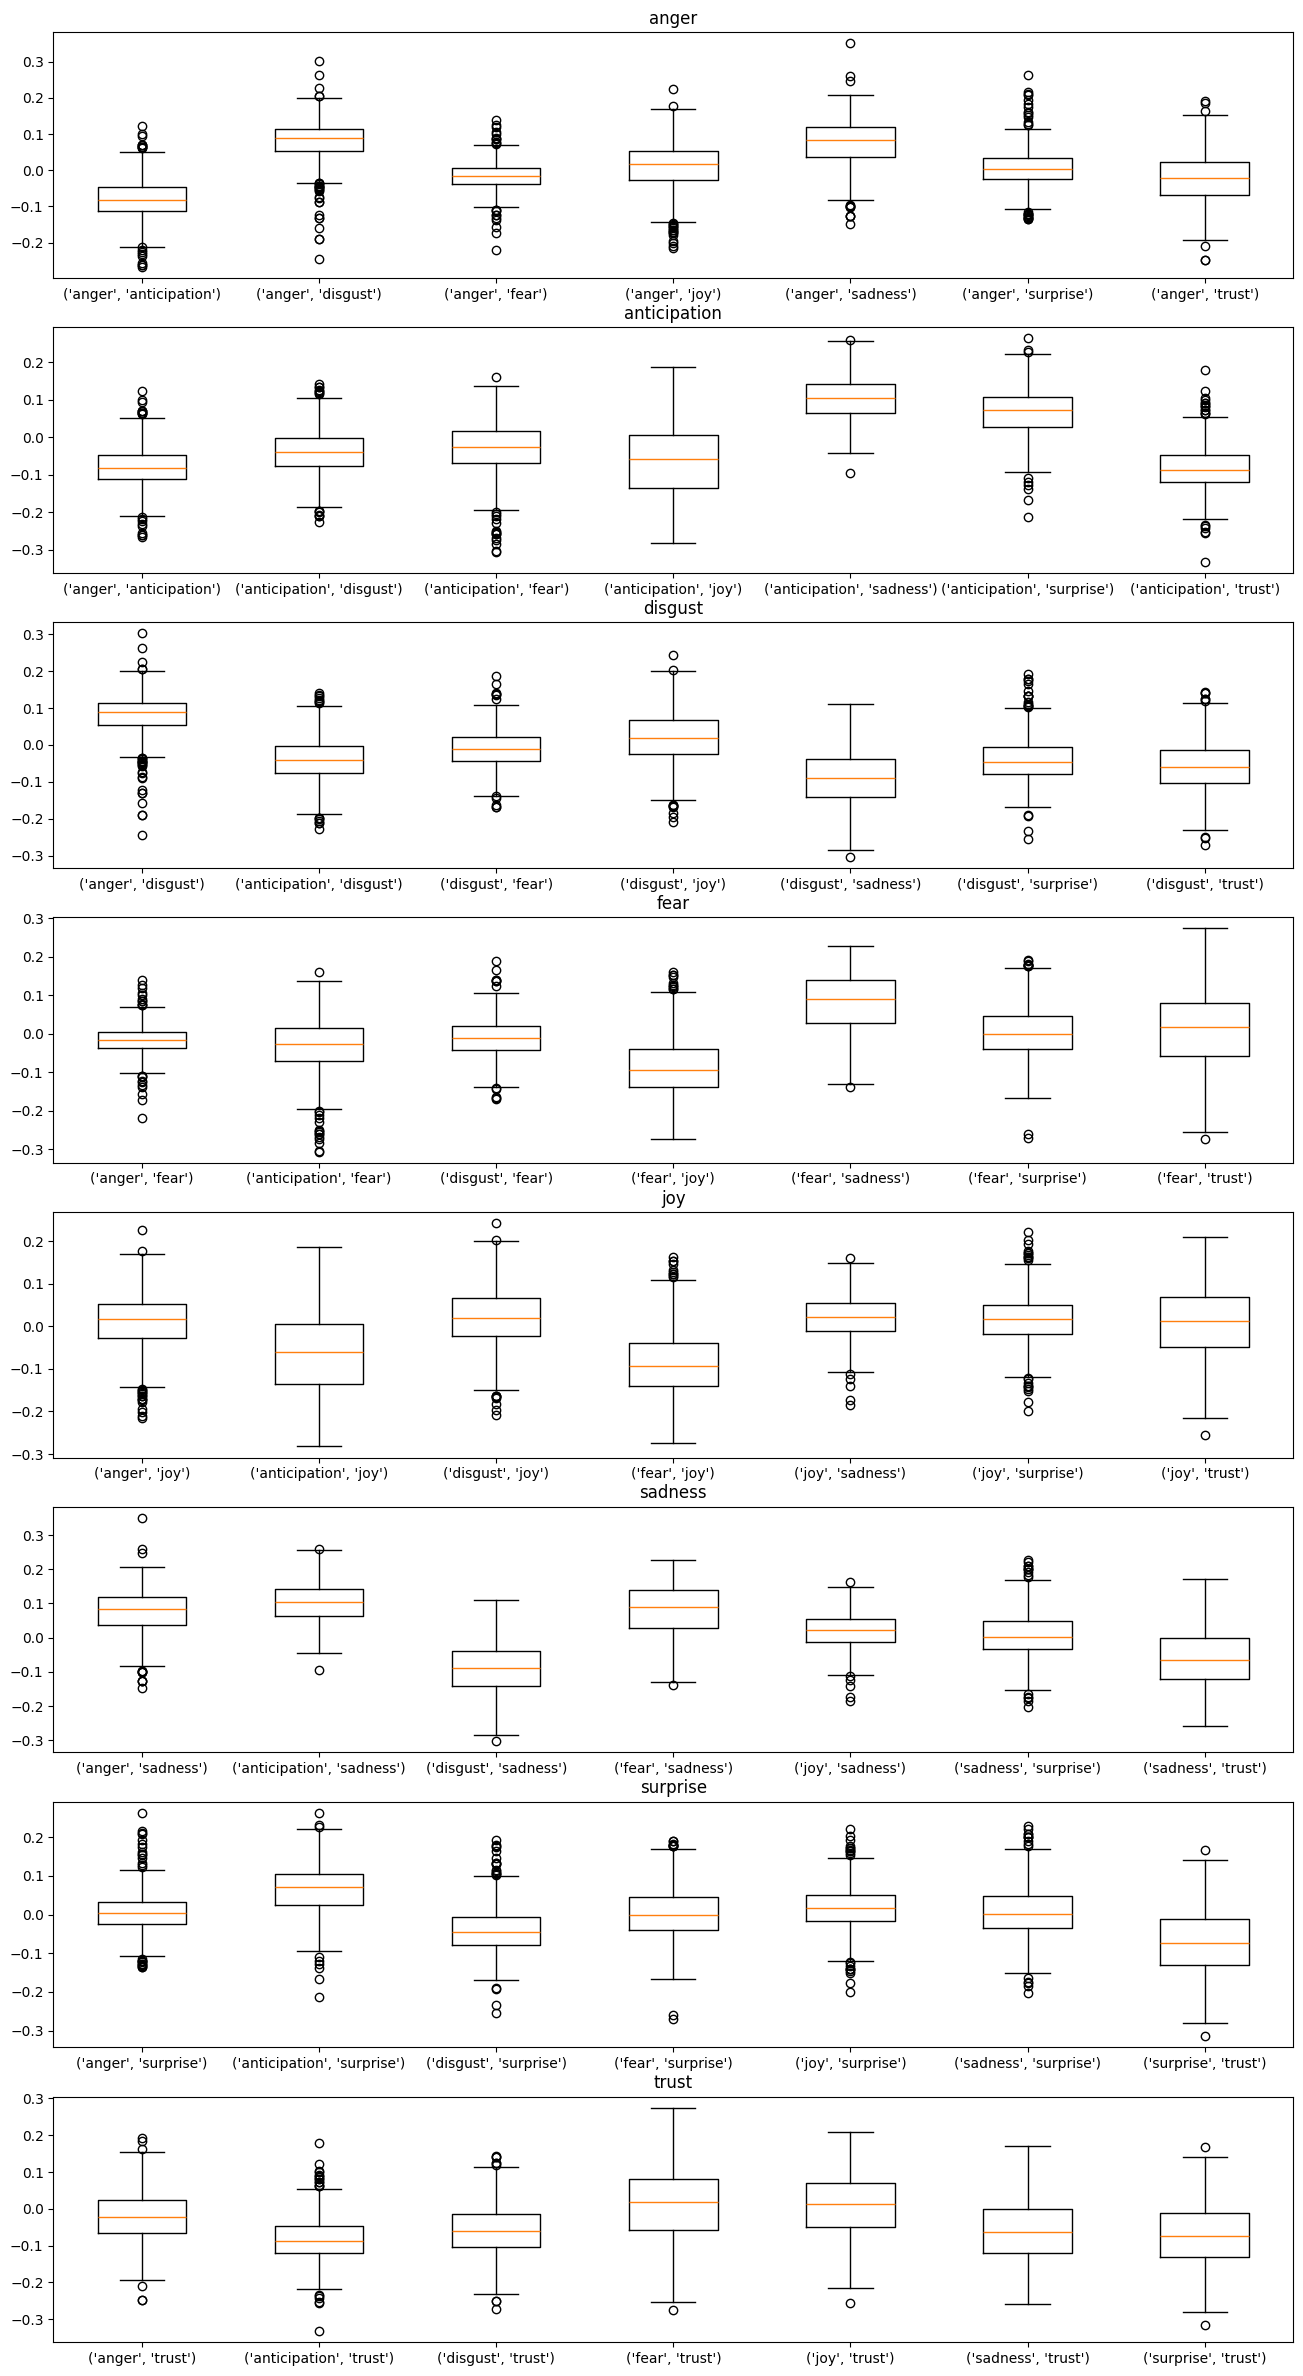

In [43]:
# Boxplots correlacion w2v modulados
import re
fig,ax = plt.subplots(8,figsize=(16,30))
columns = words_embbed_w2v_mod.columns
i = 0
for emotion in emotion_list:
    data = []
    labels = []
    for column in columns:
        if emotion in column:
            if 'f_' in column:
                continue
            data.append([element[0] for element in words_embbed_w2v_mod[column]])
            labels.append(re.sub(r"P_","",column))
    ax[i].boxplot(data)
    ax[i].set_xticklabels(labels)
    ax[i].set_title(emotion)
    i+=1

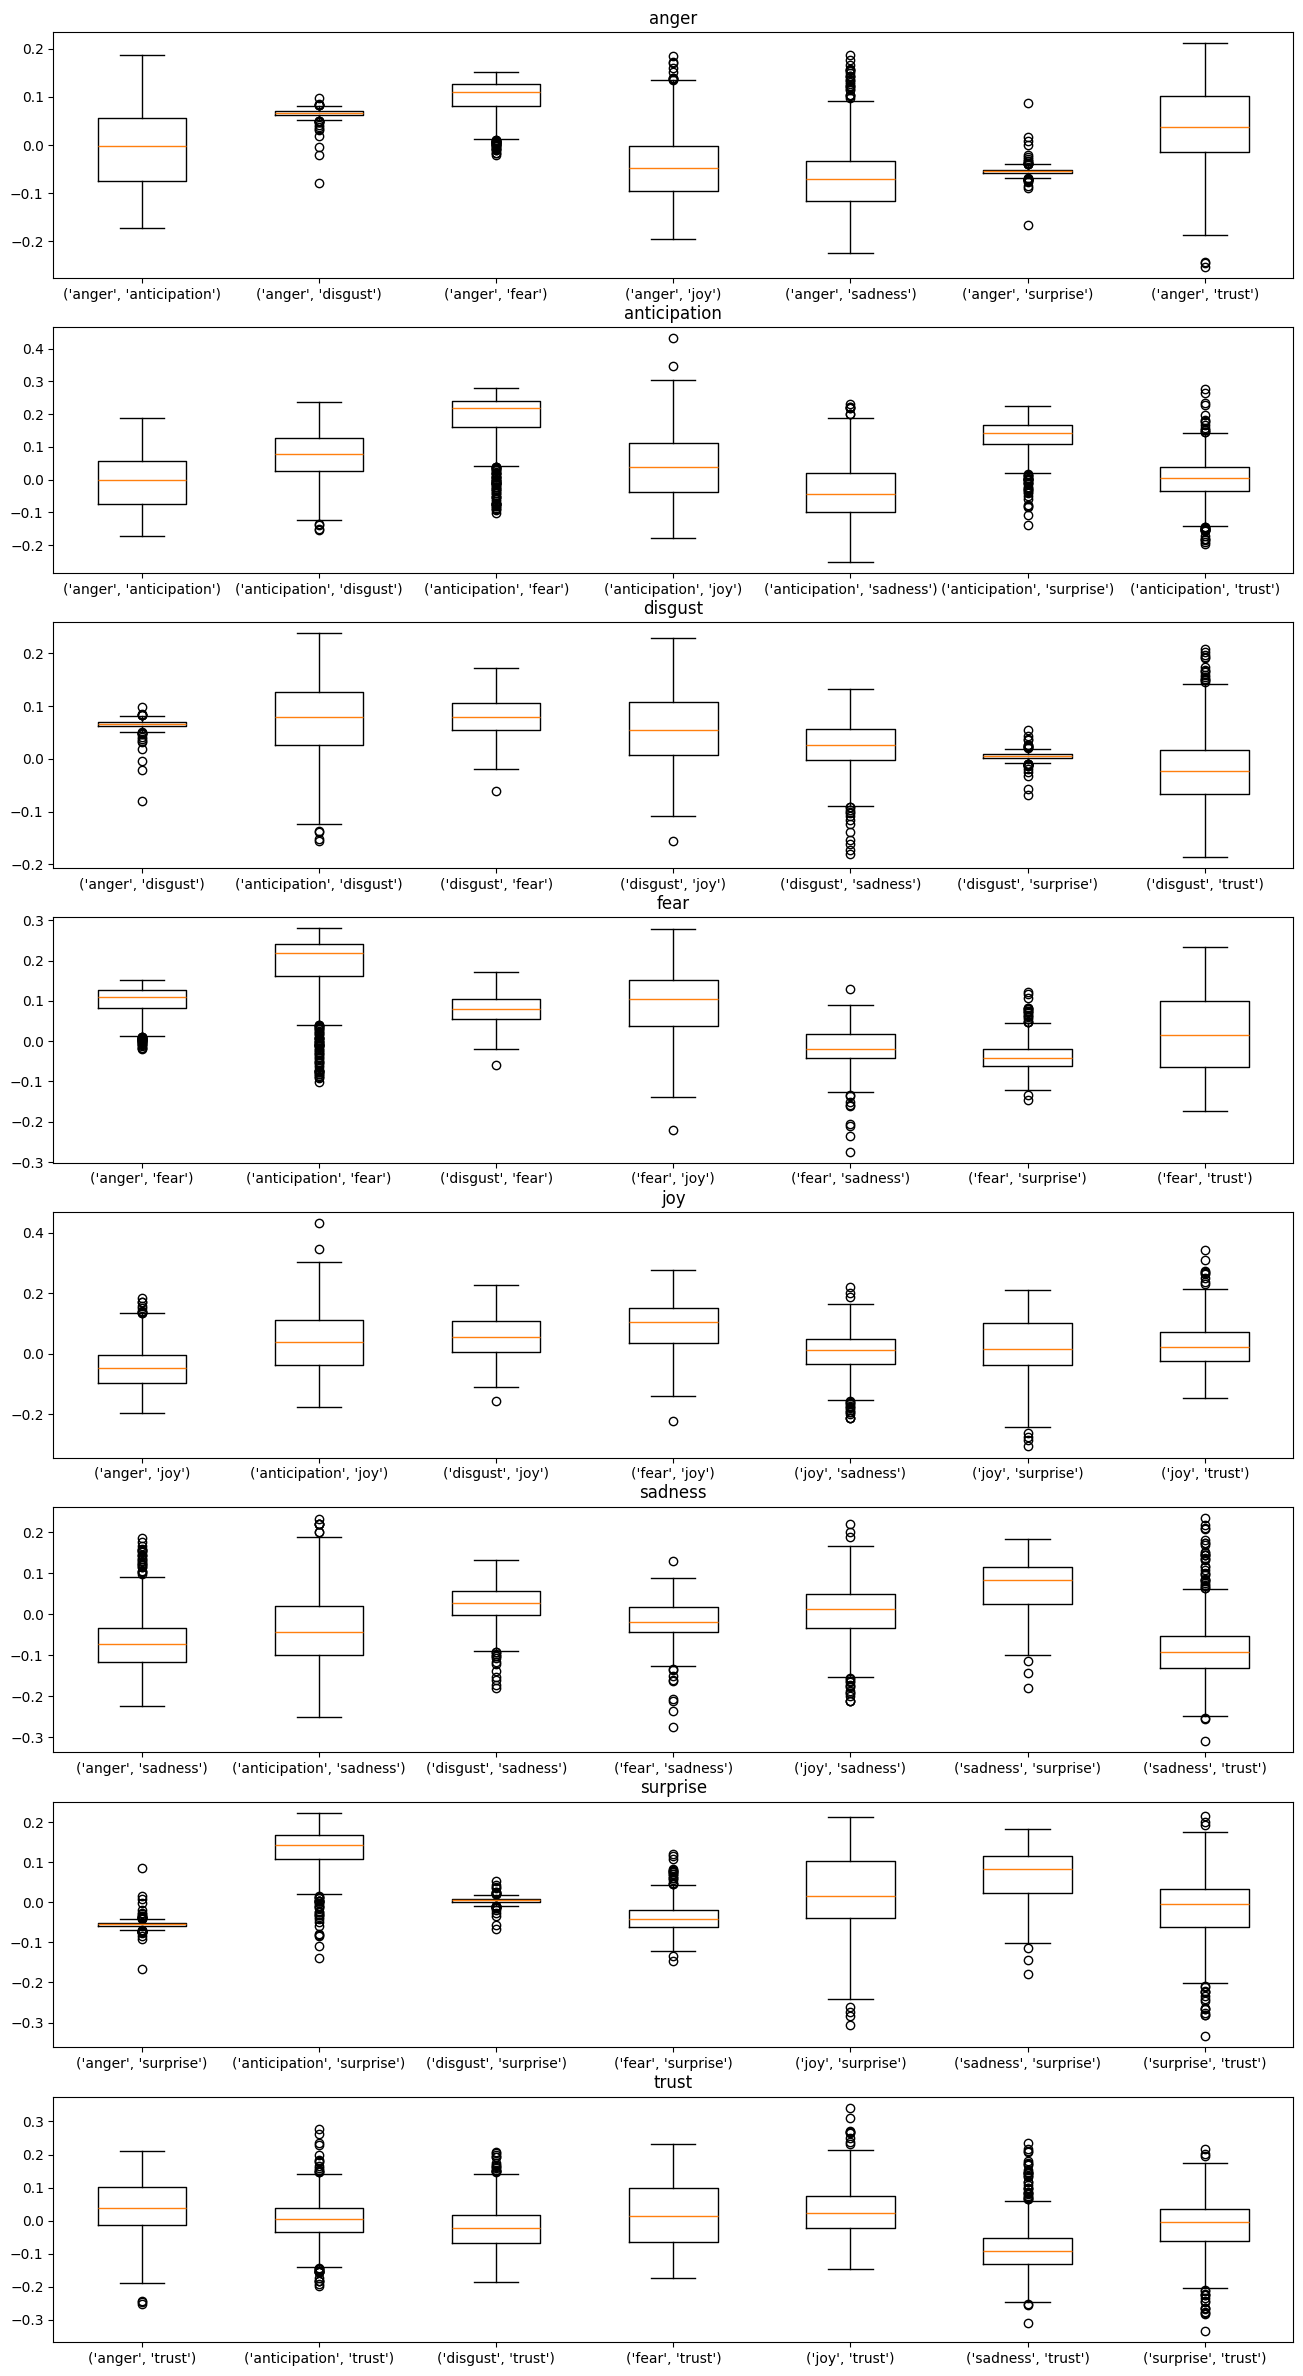

In [44]:
# Boxplots correlacion fst modulados
import re
fig,ax = plt.subplots(8,figsize=(16,30))
columns = words_embbed_fst_mod.columns
i = 0
for emotion in emotion_list:
    data = []
    labels = []
    for column in columns:
        if emotion in column:
            if 'f_' in column:
                continue
            data.append([element[0] for element in words_embbed_fst_mod[column]])
            labels.append(re.sub(r"P_","",column))
    ax[i].boxplot(data)
    ax[i].set_xticklabels(labels)
    ax[i].set_title(emotion)
    i+=1

## Uso de la frecuencia máxima para modulación de palabras

0.0


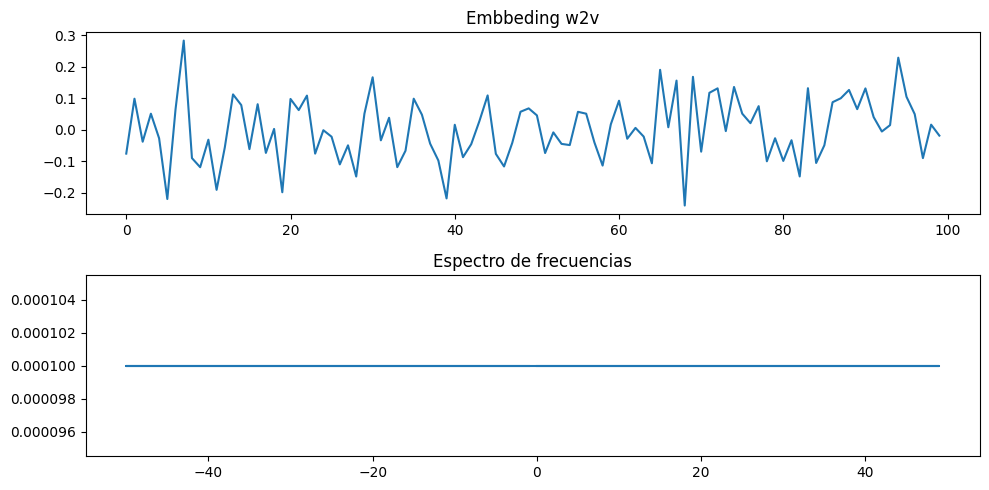

In [99]:
#Obtencion de espectro con MESA
from memspectrum import MESA

word = poems_w2v["anger"].wv.get_vector("for",norm=True)

M = MESA()
M.solve(word)
frecuencies,spectrum = M.spectrum(1/len(word))

fig,ax = plt.subplots(2,figsize=(10,5))

ax[0].set_title("Embbeding w2v")
ax[0].plot(word)

ax[1].set_title("Espectro de frecuencias")
ax[1].plot(frecuencies,spectrum)
fig.tight_layout()
print(frecuencies[np.argmax(spectrum)])

14.0


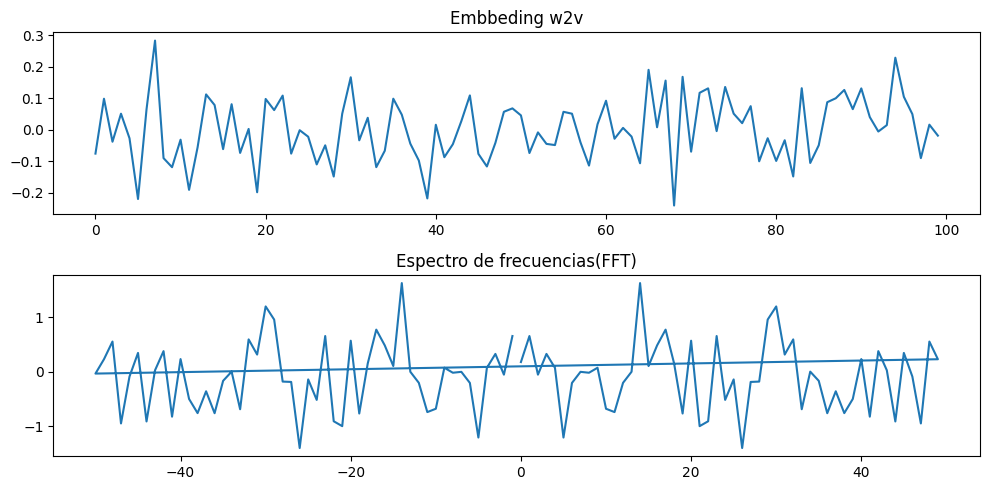

In [100]:
#Obtencion de espectro con numpy
sp = np.fft.fft(word)
freq = np.fft.fftfreq(len(word),d=1/len(word))

fig,ax = plt.subplots(2,figsize=(10,5))

ax[0].set_title("Embbeding w2v")
ax[0].plot(word)

ax[1].set_title("Espectro de frecuencias(FFT)")
ax[1].plot(freq,sp.real)
fig.tight_layout()

print(freq[np.argmax(sp.real)])

In [129]:
def get_max_freq(models,emotion_list,solver="maxent"):
    """Obtiene las frecuencias maximas de los espectros con maxent o numpy"""
    frequencies_dir = {}
    for emotion in emotion_list:
        frequencies_dir[emotion] = []

        words = models[emotion].wv.key_to_index.keys()
        
        M = MESA()
        for word in words:
            vector = models[emotion].wv.get_vector(word,norm=True)
            if solver == "maxent":
                M.solve(vector)
                frecuencies,spectrum = M.spectrum(1/len(vector))
                freq = frecuencies[np.argmax(spectrum[len(vector)//2:])]
            elif solver == "np":
                spectrum = np.fft.fft(vector)
                frecuencies = np.fft.fftfreq(len(vector),d=1/len(vector))
                freq = frecuencies[np.argmax(spectrum.real[len(vector)//2:])]
            frequencies_dir[emotion].append(freq)
    return frequencies_dir

In [130]:
freq_fst_maxent = get_max_freq(poems_fst,emotion_list)
freq_fst_np = get_max_freq(poems_fst,emotion_list,"np")

freq_w2v_maxent = get_max_freq(poems_w2v,emotion_list)
freq_w2v_np = get_max_freq(poems_w2v,emotion_list,"np")

[3.292419825072886, 2.732628593528426, 5.090008009611534, 2.850852949585438, 3.4056867225184058, 4.945, 2.8971153846153848, 2.601808615586978]
[49.0, 48.35871657754011, 48.98951612903226, 48.75073673870334, 41.755941681645695, 48.360400899979545, 49.0, 46.06849100860047]


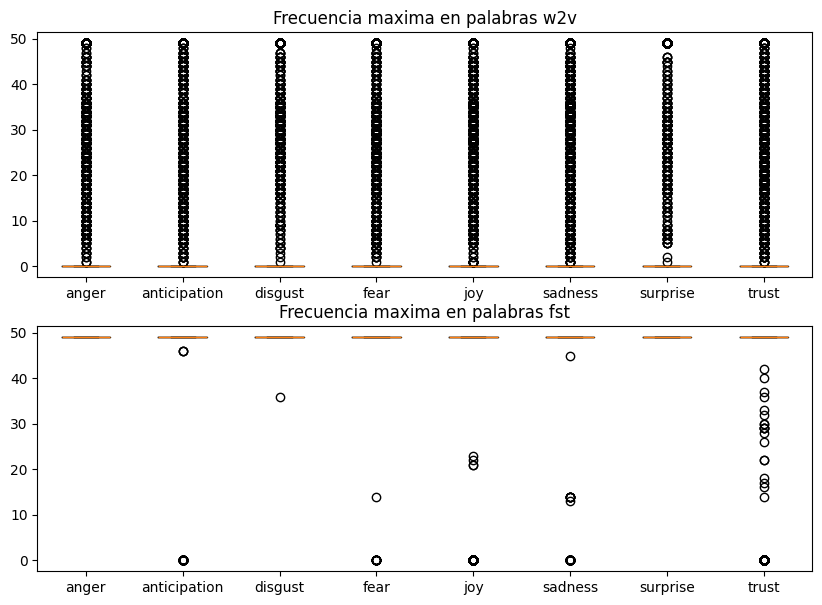

In [131]:
fig,ax = plt.subplots(2,figsize=(10,7))

labels = [label for label in freq_w2v_maxent.keys()]
data = [freq_w2v_maxent[label] for label in labels]
ax[0].boxplot(data)
ax[0].set_xticklabels(labels)
ax[0].set_title("Frecuencia maxima en palabras w2v")
medias_freq_spec_w2v = [np.mean(data[i]) for i in range(len(data))]
print(medias_freq_spec_w2v)

labels = [label for label in freq_fst_maxent.keys()]
data = [freq_fst_maxent[label] for label in labels]
ax[1].boxplot(data)
ax[1].set_xticklabels(labels)
ax[1].set_title("Frecuencia maxima en palabras fst")

medias_freq_spec_fst = [np.mean(data[i]) for i in range(len(data))]
print(medias_freq_spec_fst)

[31.471574344023324, 21.204159683726527, 31.857629154985982, 32.052463547126656, 29.815604637386816, 31.118235294117646, 27.37046703296703, 30.08605721802039]
[12.494880546075086, 44.23058823529412, 12.0, 13.679027504911591, 44.547833033752745, 16.53569237062794, 46.80520833333333, 27.001876465989053]


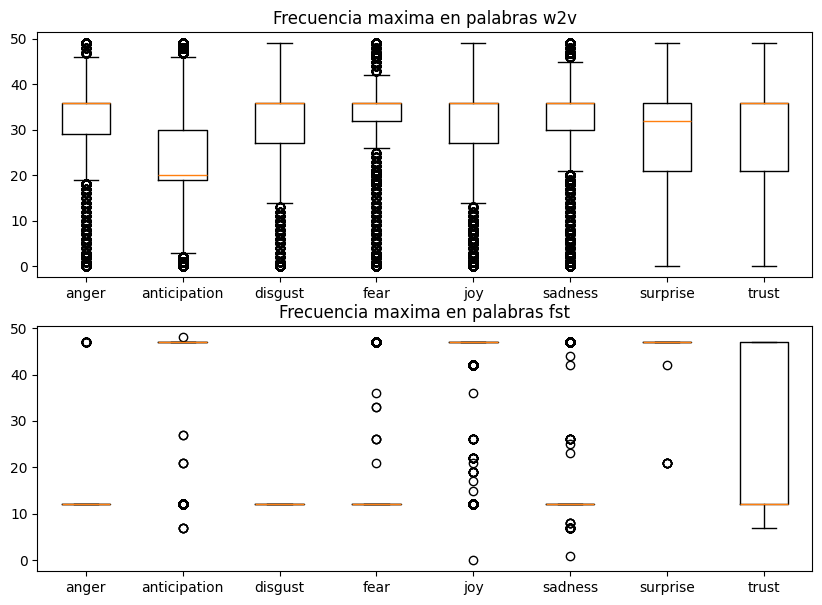

In [132]:
fig,ax = plt.subplots(2,figsize=(10,7))

labels = [label for label in freq_w2v_np.keys()]
data = [freq_w2v_np[label] for label in labels]
ax[0].boxplot(data)
ax[0].set_xticklabels(labels)
ax[0].set_title("Frecuencia maxima en palabras w2v")
medias_freq_spec_w2v = [np.mean(data[i]) for i in range(len(data))]
print(medias_freq_spec_w2v)

labels = [label for label in freq_fst_np.keys()]
data = [freq_fst_np[label] for label in labels]
ax[1].boxplot(data)
ax[1].set_xticklabels(labels)
ax[1].set_title("Frecuencia maxima en palabras fst")

medias_freq_spec_fst = [np.mean(data[i]) for i in range(len(data))]
print(medias_freq_spec_fst)

## Prueba de correlación

In [133]:
#Con los datos calculados obtenemos la media de cada clase
data = [freq_fst_maxent[label] for label in labels]
mean_fst_maxent = [np.mean(data[i]) for i in range(len(data))]

data = [freq_w2v_maxent[label] for label in labels]
mean_w2v_maxent = [np.mean(data[i]) for i in range(len(data))]

data = [freq_fst_np[label] for label in labels]
mean_fst_np = [np.mean(data[i]) for i in range(len(data))]

data = [freq_w2v_np[label] for label in labels]
mean_w2v_np = [np.mean(data[i]) for i in range(len(data))]

display(mean_fst_maxent,mean_w2v_maxent,mean_fst_np,mean_w2v_np)

[49.0,
 48.35871657754011,
 48.98951612903226,
 48.75073673870334,
 41.755941681645695,
 48.360400899979545,
 49.0,
 46.06849100860047]

[3.292419825072886,
 2.732628593528426,
 5.090008009611534,
 2.850852949585438,
 3.4056867225184058,
 4.945,
 2.8971153846153848,
 2.601808615586978]

[12.494880546075086,
 44.23058823529412,
 12.0,
 13.679027504911591,
 44.547833033752745,
 16.53569237062794,
 46.80520833333333,
 27.001876465989053]

[31.471574344023324,
 21.204159683726527,
 31.857629154985982,
 32.052463547126656,
 29.815604637386816,
 31.118235294117646,
 27.37046703296703,
 30.08605721802039]

In [134]:
def scale(x):
    """Escala entre 0 y 1 los valores de x"""
    return (x-np.min(x))/(np.max(x)-np.min(x))

In [136]:
#Escalamos entre 0 y 1 los valores medios de las frecuencias
mean_fst_maxent = scale(mean_fst_maxent)
mean_w2v_maxent = scale(mean_w2v_maxent)
mean_fst_np = scale(mean_fst_np)
mean_w2v_np = scale(mean_w2v_np)

display(mean_fst_maxent,mean_w2v_maxent,mean_fst_np,mean_w2v_np)

array([1.        , 0.91147456, 0.99855276, 0.96559066, 0.        ,
       0.91170707, 1.        , 0.59532228])

array([0.27755461, 0.05257616, 1.        , 0.10009018, 0.32307624,
       0.94172171, 0.11868292, 0.        ])

array([0.01421858, 0.92602773, 0.        , 0.0482407 , 0.9351426 ,
       0.13031648, 1.        , 0.4310239 ])

array([0.94645345, 0.        , 0.98204011, 1.        , 0.79380565,
       0.91388255, 0.56841212, 0.81873606])

In [ ]:
def create_correlation_df_mod(models,emotion_list,words_intersection,freq_dict,freq_a,freq_b,norm = False):
    emotion_combinations = list(combinations(emotion_list,2))

    words_embbed_info = {}
    words_embbed_info["words"] = list(words_intersection)

    for emotion in emotion_list:
        words_embbed_info["f_"+emotion] = []

    for comb in emotion_combinations:
        words_embbed_info["P_"+str(comb)] = []

    for word in words_intersection:
        #Añadimos la frecuencia por cada emoción
        for emotion in emotion_list:
            words_embbed_info["f_"+emotion].append(freq_dict[emotion][word])

        #Calculamos la correlacion pearson para cada par de emociones.    
        for comb in emotion_combinations:
            emotion_a = comb[0]
            emotion_b = comb[1]

            embbeding_a = models[emotion_a].wv.get_vector(word,norm=True)
            embbeding_b = models[emotion_b].wv.get_vector(word,norm=True)

            fm_embbed_a = modulate(embbeding_a,freq_a,50,100,1)
            fm_embbed_b = modulate(embbeding_b,freq_b,50,100,1)
            
            if norm:
                fm_embbed_a = fm_embbed_a/np.linalg.norm(fm_embbed_a)
                fm_embbed_b = fm_embbed_b/np.linalg.norm(fm_embbed_b)


            words_embbed_info["P_"+str(comb)].append(pearsonr(fm_embbed_a,fm_embbed_b))

    return pd.DataFrame(words_embbed_info)